# The impact of grid and velocity interpolation scheme on trajectories

The notebook below shows how sensitive trajectories are to the combination of grid and velocity interpolation schemes. We will use the Peninsula example (also discussed in the [Quickstart to Parcels tutorial](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Sampling-a-Field-with-Particles)), but carefully compare how trajectories on the [A-grid and C-grid](https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html) version of this flow differ. To enhance the differences, we deliberately use a very course-resolution grid.

In [1]:
import parcels
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy

We start with defining the `FieldSet` for the Peninsula flow and the grid. Note that on the A-grid we can directly calculate the velocities on the grid pints from the streamfunction `P`. On the C-grid, we need to differentiate the streamfunction `P` to get the velocities on the staggered `U` and `V` grid points.

In [2]:
def peninsula_fieldset(xdim=14, ydim=16, grid_type="A", interp_method="linear"):
    domainsizeX, domainsizeY = (1.0e5, 5.0e4)
    lon = np.linspace(0, domainsizeX, xdim, dtype=np.float32)
    lat = np.linspace(0, domainsizeY, ydim, dtype=np.float32)

    u0 = 1
    x0 = domainsizeX / 2
    R = 0.32 * domainsizeX / 2

    x, y = np.meshgrid(lon, lat, sparse=True, indexing="xy")
    P = u0 * R**2 * y / ((x - x0) ** 2 + y**2) - u0 * y
    landpoints = P >= 0.0
    P[landpoints] = 0.0

    if grid_type == "A":
        U = u0 - u0 * R**2 * ((x - x0) ** 2 - y**2) / (((x - x0) ** 2 + y**2) ** 2)
        V = -2 * u0 * R**2 * ((x - x0) * y) / (((x - x0) ** 2 + y**2) ** 2)
        U[landpoints] = 0.0
        V[landpoints] = 0.0
    elif grid_type == "C":
        U = np.zeros(P.shape)
        V = np.zeros(P.shape)
        V[:, 1:] = (P[:, 1:] - P[:, :-1]) / (lon[1] - lon[0])
        U[1:, :] = -(P[1:, :] - P[:-1, :]) / (lat[1] - lat[0])

    data = {"U": U, "V": V, "P": P}
    dimensions = {"lon": lon, "lat": lat}

    fieldset = parcels.FieldSet.from_data(data, dimensions, mesh="flat")
    fieldset.U.interp_method = interp_method
    fieldset.V.interp_method = interp_method
    return fieldset

Next, we define some helper Kernels and the ParticleType.

In [3]:
def SampleP(particle, fieldset, time):
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]


def DeleteParticle(particle, fieldset, time):
    if particle.state >= 50:
        particle.delete()


ptype = parcels.ScipyParticle.add_variables({"p": np.float32})

Now we run six different experiments, each with a different combination of grid type ("A" or "C") and velocity interpolation scheme (["linear"](https://docs.oceanparcels.org/en/latest/examples/tutorial_interpolation.html), ["freeslip"](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#3.-Slip-boundary-conditions), ["cgrid_velocity"](https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html) and ["analytical"](https://docs.oceanparcels.org/en/latest/examples/tutorial_analyticaladvection.html)).

In [4]:
exps = [
    ["A", "linear"],
    ["A", "freeslip"],
    ["C", "cgrid_velocity"],
    ["C", "analytical"],
    ["A", "cgrid_velocity"],
    ["C", "linear"],
]

dt = 1e3  # setting output and execution timestep to same value

for grid_type, interp_method in exps:
    interp_method_fieldset = (
        interp_method if interp_method != "analytical" else "cgrid_velocity"
    )
    fieldset = peninsula_fieldset(
        grid_type=grid_type, interp_method=interp_method_fieldset
    )

    pset = parcels.ParticleSet.from_line(
        fieldset, pclass=ptype, size=7, start=(1e3, 1e3), finish=(1e3, 10e3)
    )
    outfile = pset.ParticleFile(name=f"Trajs_{grid_type}_{interp_method}", outputdt=dt)

    adv_kernel = (
        parcels.AdvectionAnalytical
        if interp_method == "analytical"
        else parcels.AdvectionRK4
    )
    pset.execute(
        [adv_kernel, SampleP, DeleteParticle], endtime=1e5, dt=dt, output_file=outfile
    )

INFO: Output files are stored in Trajs_A_linear.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 17286.21it/s]
INFO: Output files are stored in Trajs_A_freeslip.zarr.
100%|██████████| 100000.0/100000.0 [00:06<00:00, 16298.23it/s]
INFO: Output files are stored in Trajs_C_cgrid_velocity.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 18141.74it/s]
INFO: Output files are stored in Trajs_C_analytical.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 18168.13it/s]
INFO: Output files are stored in Trajs_A_cgrid_velocity.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 18571.33it/s]
INFO: Output files are stored in Trajs_C_linear.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 17803.16it/s]


Then we load all six experiments into a dictionary for plotting later.

In [5]:
data_trajs = {}
for grid_type, interp_method in exps:
    interp_name = (
        f"{interp_method} interpolation"
        if interp_method != "analytical"
        else f"{interp_method} advection"
    )
    exp_name = f"{grid_type}grid & {interp_name.replace("_velocity", "")}"
    data_trajs[exp_name] = xr.open_zarr(f"Trajs_{grid_type}_{interp_method}.zarr")

We carefully compute the landmask (i.e. where the peninsula field has land), which is important for the interpretation of land that is consistent with Parcels (see also the [Preventing stuck particles tutorial](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#2.-Displacement)).

In [6]:
landmask = np.ma.masked_values(fieldset.U.data[0, :, :], 0)
landmask = landmask.mask.astype("int")

lonplot, latplot = np.meshgrid(fieldset.U.lon, fieldset.U.lat)

fl = scipy.interpolate.RectBivariateSpline(
    fieldset.U.lat, fieldset.U.lon, landmask, kx=1, ky=1
)
x = fieldset.U.lon[:-1] + np.diff(fieldset.U.lon) / 2
y = fieldset.U.lat[:-1] + np.diff(fieldset.U.lat) / 2
lon_centers, lat_centers = np.meshgrid(x, y)
l_centers = fl(lat_centers[:, 0], lon_centers[0, :])
lmask = np.ma.masked_values(l_centers, 1)

Then, we finally plot the trajectories for all six experiments. We see that the trajectories are very sensitive to the combination of grid and velocity interpolation scheme. Note for example that using `cgrid_velocity` interpolation on an A-grid (fifth panel) leads to particles getting grounded on the land, which is not physical.

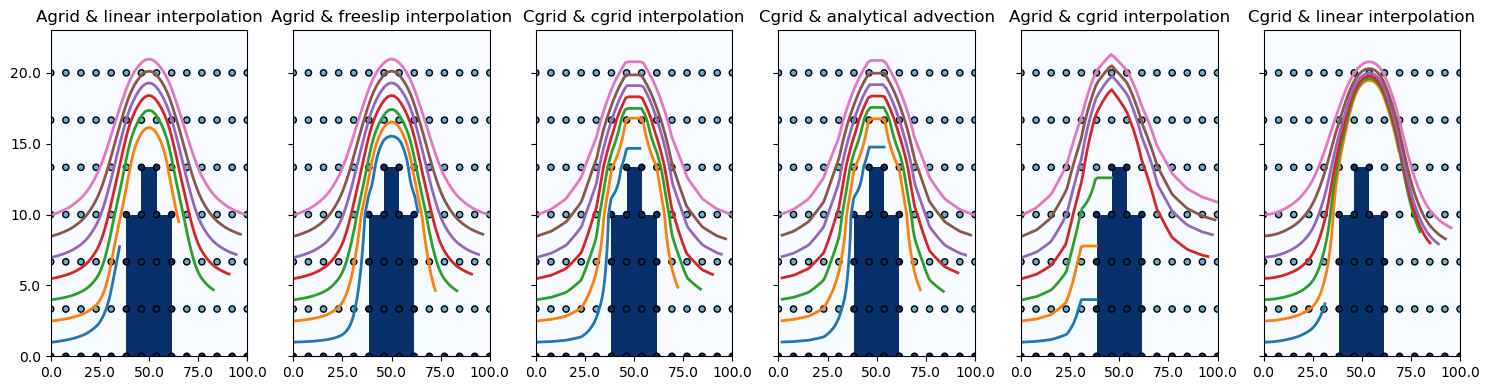

In [7]:
fig, ax = plt.subplots(1, len(data_trajs), figsize=(15, 4))

for a, exp_name in zip(ax, data_trajs):
    a.pcolormesh(lonplot, latplot, lmask.mask, cmap="Blues")
    a.scatter(
        lonplot,
        latplot,
        c=landmask,
        s=20,
        cmap="Blues",
        vmin=-0.05,
        vmax=0.05,
        edgecolors="k",
    )
    a.plot(data_trajs[exp_name]["lon"].T, data_trajs[exp_name]["lat"].T, linewidth=2)
    a.set_title(exp_name)

# Set the same limits for all subplots
for a in ax:
    a.set_xlim([fieldset.U.lon.min(), fieldset.U.lon.max()])
    a.set_ylim([0, 23e3])
    m2km = lambda x, _: f"{x/1000:.1f}"
    a.xaxis.set_major_formatter(m2km)
    a.yaxis.set_major_formatter(m2km)

for a in ax[1:]:
    a.set_yticklabels([])

plt.tight_layout()
plt.show()

Because we know that Particles have to follow lines of constant streamfunction, we can also plot the streamlines of the flow field. When we overlay the "Agrid & linear interpolation" and "Cgrid & cgrid interpolation" trajectories onto these streamlines, we see that they are subtly different.

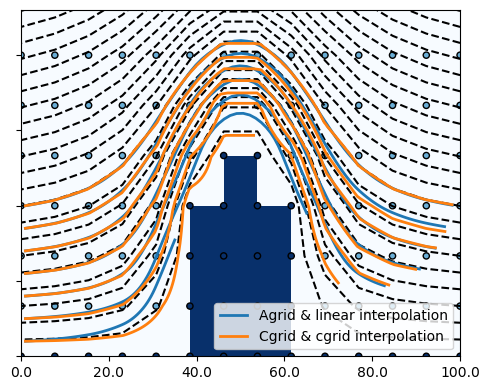

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.pcolormesh(lonplot, latplot, lmask.mask, cmap="Blues")
ax.scatter(
    lonplot,
    latplot,
    c=landmask,
    s=20,
    cmap="Blues",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax.contour(lonplot, latplot, fieldset.P.data[0, :, :], colors="k", levels=50)


for i, exp_name in enumerate(
    ["Agrid & linear interpolation", "Cgrid & cgrid interpolation"]
):
    ax.plot(
        data_trajs[exp_name]["lon"][0, :].T,
        data_trajs[exp_name]["lat"][0, :].T,
        linewidth=2,
        color=f"C{i:02d}",
        label=exp_name,
    )
    ax.plot(
        data_trajs[exp_name]["lon"][1:, :].T,
        data_trajs[exp_name]["lat"][1:, :].T,
        linewidth=2,
        color=f"C{i:02d}",
        label="_nolegend_",
    )

ax.legend()
ax.set_xlim([fieldset.U.lon.min(), fieldset.U.lon.max()])
ax.set_ylim([0, 23e3])
m2km = lambda x, _: f"{x/1000:.1f}"
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)

ax.set_yticklabels([])

plt.tight_layout()
plt.show()

To further investigate the differences, we can also plot the change in the streamfunction value sampled by the particle (`particle.p`) between the final and start location for each experiment. We see that the difference is larger for particles that start farther south and thus get closer to the peninsula. The difference in streamfunction change for the particle that started farthest north is very close to zero for all of the first four experiments; and much larger for the fifth and sixth experiments (where the grid and interpolation scheme do not match up). 

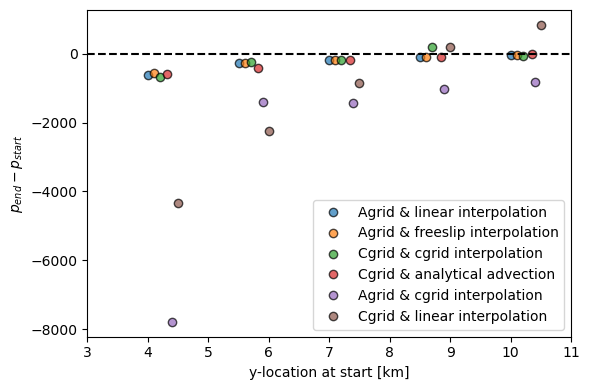

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, exp_name in enumerate(data_trajs):
    ax.plot(
        data_trajs[exp_name].lat[2:, 0] / 1e3 + i / 10,
        data_trajs[exp_name].p[2:, -1] - data_trajs[exp_name].p[2:, 0],
        "o",
        alpha=0.7,
        label=exp_name,
        markeredgecolor="k",
    )
ax.legend(loc="lower right")
ax.hlines(0, 3, 11, linestyles="--", color="k")
ax.set_xlabel("y-location at start [km]")
ax.set_xlim([3, 11])
# ax.set_ylim([-1000, 1000])
ax.set_ylabel("$p_{end} - p_{start}$")
plt.tight_layout()
plt.show()

This clearly shows why it is important to consider the combination of grid and interpolation scheme when running Parcels simulations.